## Evaluation metrics for binary classification

- This week we covered evaluation metrics for binary classification such as:
    * Confusion matrix
    * Precision and recall
    * ROC curves
    * Area under curves (AUC)

- In this homework, we will use credit card data anf the goal is to inspect the output of different evaluation metrics by creating a classification model. Target column is card.

In [175]:
# import the libraries

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

## Data Preparation

- Create the target variable by mapping yes to 1 and no to 0.
- split the data into train, validation and test sets

In [176]:
# Fetching the data 
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv'

df = pd.read_csv(url)

print(f'DF INFO: {df.info()}')
print('*' *50)
print(f'Shape: {df.shape}')

# Creating the target variable 
df.card = (df.card == 'yes').astype(int)

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB
DF INFO: None
**************************************************
Shape: (1319, 12)


,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [177]:
# Splitting the data in train/val/test sets, with 60%/20%/20% distribution.

# train and test split
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

# train and validation split
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

len(df_train), len(df_test), len(df_val)

(791, 264, 264)

In [178]:
# Resetting the indices 
df_train.reset_index(drop=True)
df_test.reset_index(drop=True)
df_val.reset_index(drop=True)

# Getting the y variables
y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

# Removing the target variable
df_train.drop(['card'], axis=1, inplace=True)
df_val.drop(['card'], axis=1, inplace=True)
df_test.drop(['card'], axis=1, inplace=True)

## Question 1

- Evaluate feature importance using ROC AUC
    - For each numerical variable, use it as score and compute AUC with the card variable.
    - Use the training dataset for that.

- If your AUC is < 0.5, invert this variable by putting "-" in front

- Which numerical variable (among the following 4) has the highest AUC?

    - reports
    - dependents
    - active
    - share

In [179]:
# Selecting all numeric columns
numerical = df_train.select_dtypes(include='number')

# Calculate ROC AUC for numerical variables 
for i in numerical:
    roc_auc = roc_auc_score(y_train, df_train[i])
    if roc_auc < 0.5:
        roc_auc = roc_auc_score(y_train, -df_train[i])
    print(f'AUC of {i}: {roc_auc}')

AUC of reports: 0.7166629860689376
AUC of age: 0.5240020979407055
AUC of income: 0.5908049467233478
AUC of share: 0.989183643423692
AUC of expenditure: 0.991042345276873
AUC of dependents: 0.5327757227773791
AUC of months: 0.5294217780967629
AUC of majorcards: 0.5343859842838476
AUC of active: 0.6043173411362006


<b>Share</b> has the highest AUC

### 1.1 Training the model

From now on, use these columns only:

["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [180]:
cols = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

df_train_small = df_train[cols]
df_test_small = df_test[cols]
df_val_small = df_val[cols]

In [181]:
# One-hot encoding the categorical feature using DictVectorizer
train_dict = df_train_small.to_dict(orient='records')

# Creating an instance of DictVectorizer
dv = DictVectorizer(sparse=False)

# Fitting and transforming the dictionary
X_train = dv.fit_transform(train_dict)

# Doing the same on validation set (transforming only)
val_dict = df_val_small.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [182]:
# Logistic regression
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Predicting on validation set 
y_pred = model.predict_proba(X_val)[:, 1]

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [183]:
# AUC score
AUC_val = round(roc_auc_score(y_val, y_pred),3)
print(f'AUC of model: {AUC_val}')

AUC of model: 0.995


## Question 3

- Compute precision and recall for the model
- Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them
- At which threshold precision and recall curves intersect?

    - 0.1
    - 0.3
    - 0.6
    - 0.8

In [194]:
# Function that returns a dataframe with precision and recall values plus 
# TN, FN, FP, TP at thresholds from 0 to 1 with step 0.01

def pr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    
    return df_scores

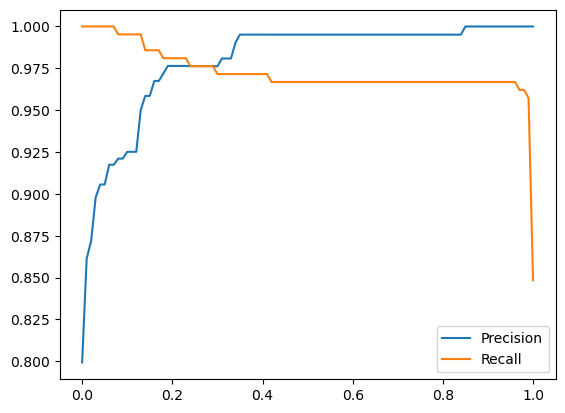

In [195]:
# Dataframe for precision and recall values plus 
# TN, FN, FP, TP
df_pr_curve = pr_dataframe(y_val, y_pred)

# Create the Precision-Recall curve 
plt.plot(df_pr_curve.threshold, df_pr_curve['precision'], label='Precision')
plt.plot(df_pr_curve.threshold, df_pr_curve['recall'], label='Recall')
plt.legend()

Precision and recall curves intersect at <b>0.3</b>

## Question 4

- Compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set
- At which threshold F1 is maximal?

    - 0.1
    - 0.4
    - 0.6
    - 0.7
    
This is the formula for computing $F_1$:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.



In [196]:
# Calculating the F1 score
df_pr_curve['F1_score'] = 2 * ((df_pr_curve.precision * df_pr_curve.recall)/(df_pr_curve.precision + df_pr_curve.recall))
                                                                                                                     

In [197]:
# Gettimg the maximum threshold
df_pr_curve[df_pr_curve['F1_score'] == df_pr_curve.F1_score.max()] 

,threshold,tp,fp,fn,tn,precision,recall,F1_score
35,0.35,205,1,6,52,0.995146,0.971564,0.983213
36,0.36,205,1,6,52,0.995146,0.971564,0.983213
37,0.37,205,1,6,52,0.995146,0.971564,0.983213
38,0.38,205,1,6,52,0.995146,0.971564,0.983213
39,0.39,205,1,6,52,0.995146,0.971564,0.983213
40,0.40,205,1,6,52,0.995146,0.971564,0.983213
41,0.41,205,1,6,52,0.995146,0.971564,0.983213


Threshold with maximal F1 score: <b>0.35</b>

## Question 5

- Using KFold class from scikit-learn:
    - Iterate over different folds of df_full_train
    - Split the data into train and validation
    - Train the model on train using logistic regression
    - Use AUC to evaluate the model on validation

In [198]:
# LogReg trainer

def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [199]:
# Predicting values

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [200]:
# Evaluating model on 5 kfolds:

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [201]:
# Standatd deviatuon across different folds
print(f'Std deviation: {round(np.std(scores),4)}')

Std deviation: 0.0


## Question 6

- Using 5-Fold cross-validation to find the best parameter C

    - Iterate over the following C values: [0.01, 0.1, 1, 10]
    - Initialize KFold with the same parameters as previously
    - Use these parametes for the model
            LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    - Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [202]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.993 +- 0.005
C=0.1 0.999 +- 0.001
C=1 1.000 +- 0.000
C=10 1.000 +- 0.000


C that leads to the best mean score: <b>